In [1]:
import os, sys, urllib, gzip
sys.path.append('/home/rui/pylearn2')
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

import numpy as np
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
import pylearn2
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
from lasagne.regularization import regularize_layer_params, l2, l1
import theano
import theano.tensor as T
import time
import lasagne
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


Using cuda_convnet (faster)


In [2]:
data = np.load('output/mars.npz')

In [3]:
data1 = data['arr_0']
data_out1 = data['arr_1']
data2 = data['arr_2']
data_out2 = data['arr_3']
data3 = data['arr_4']
data_out3 = data['arr_5']
data4 = data['arr_6']
data_out4 = data['arr_7']

In [4]:
X = np.concatenate((data1,data2,data3,data4))
X = np.asarray(X, dtype = np.float32)
X = np.reshape(X, (200, 1, 64, 64))

In [5]:
X = X / 255
X_out = X.reshape((X.shape[0], -1))

In [6]:
def get_picture_array(X, rescale=2):
    array = X.reshape(64,64)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

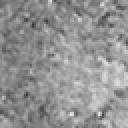

In [7]:
pic_array = get_picture_array(X[2]*255)
image = Image.fromarray(pic_array)
image.save('./output/temp.png', format="PNG")  
IPImage('./output/temp.png')

In [8]:
conv_num_filters = 16
filter_size = 5
pool_size = 2
encode_size = 64
pad_in = 'valid'    
pad_out = 'full'

In [9]:
def build_cnn(input_var=None):
    
    network = InputLayer(shape=(None,  X.shape[1], X.shape[2], X.shape[3]),input_var=input_var)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)

    network = Conv2DLayerFast(network, num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)
    
    network = Conv2DLayerFast(network, num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)
    
    network = ReshapeLayer(network, shape =(([0], -1)))
    
    
    encode_layer = DenseLayer(network, name= 'encode', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    
    network = DenseLayer(encode_layer, num_units= 3200, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    network = ReshapeLayer(network, shape =(([0], 2*conv_num_filters, 10, 10)))
    
    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, num_filters=2 * conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)

    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.tanh, filter_size=filter_size, pad=pad_out)

    network = Conv2DLayerSlow(network, num_filters=1, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.sigmoid, filter_size=filter_size, pad=pad_out)
    
    network = ReshapeLayer(network, shape =(([0], -1)))

    return network

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [11]:
np.savez('./output/autoencoder_mars.npz', *lasagne.layers.get_all_param_values(network))

In [10]:
num_epochs = 1000
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
learnrate=0.01
# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")
network = build_cnn(input_var)
reconstructed = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
   loss, params, learning_rate=learnrate, momentum=0.975)
# updates = lasagne.updates.rmsprop(loss, params, learning_rate=learnrate)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
best_err = 0.03
print("Starting training...")
for epoch in range(num_epochs):
    start_time = time.time()
    train_err = train_fn(X, X_out)
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("training loss:\t\t{:.6f}".format(float(train_err)))
#     if train_err < best_err:
#         best_err = train_err
#         np.savez('./output/autoencoder_mars.npz', *lasagne.layers.get_all_param_values(network))

Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.717s
training loss:		0.027666
Epoch 2 of 1000 took 0.702s
training loss:		0.027666
Epoch 3 of 1000 took 0.706s
training loss:		0.027666
Epoch 4 of 1000 took 0.705s
training loss:		0.027666
Epoch 5 of 1000 took 0.704s
training loss:		0.027665
Epoch 6 of 1000 took 0.703s
training loss:		0.027665
Epoch 7 of 1000 took 0.704s
training loss:		0.027665
Epoch 8 of 1000 took 0.702s
training loss:		0.027665
Epoch 9 of 1000 took 0.704s
training loss:		0.027665
Epoch 10 of 1000 took 0.703s
training loss:		0.027664
Epoch 11 of 1000 took 0.703s
training loss:		0.027664
Epoch 12 of 1000 took 0.703s
training loss:		0.027664
Epoch 13 of 1000 took 0.704s
training loss:		0.027664
Epoch 14 of 1000 took 0.704s
training loss:		0.027663
Epoch 15 of 1000 took 0.703s
training loss:		0.027663
Epoch 16 of 1000 took 0.703s
training loss:		0.027662
Epoch 17 of 1000 took 0.704s
training loss:		0.027662
Epoch 18 of 1000 took 0.706s

In [11]:
num_epochs = 2000
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
learnrate=0.005
# Create neural network model (depending on first command line parameter)
print("Building model and compiling functions...")
network = build_cnn(input_var)
reconstructed = lasagne.layers.get_output(network)
loss = lasagne.objectives.squared_error(reconstructed, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable=True)

with np.load('./output/autoencoder_mars.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

Building model and compiling functions...


In [13]:
num_epochs = 500
updates = lasagne.updates.nesterov_momentum(
    loss, params, learning_rate=0.0005, momentum=0.975)
# updates = lasagne.updates.rmsprop(
#     loss, params[10:12], learning_rate=0.01)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
best_err = 0.02
for epoch in range(num_epochs):
    start_time = time.time()
    train_err = train_fn(X, X_out)
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print(train_err)
    print("training loss:\t\t{:.6f}".format(float(train_err)))
    if train_err < best_err:
        best_err = train_err
        np.savez('./output/autoencoder_mars.npz', *lasagne.layers.get_all_param_values(network))

Starting training...
Epoch 1 of 500 took 0.361s
0.0014875360066071153
training loss:		0.001488
Epoch 2 of 500 took 0.334s
0.001248935703188181
training loss:		0.001249
Epoch 3 of 500 took 0.332s
0.001231659553013742
training loss:		0.001232
Epoch 4 of 500 took 0.332s
0.0012827329337596893
training loss:		0.001283
Epoch 5 of 500 took 0.332s
0.0012903702445328236
training loss:		0.001290
Epoch 6 of 500 took 0.332s
0.0012558357557281852
training loss:		0.001256
Epoch 7 of 500 took 0.332s
0.0012255150359123945
training loss:		0.001226
Epoch 8 of 500 took 0.332s
0.001219461322762072
training loss:		0.001219
Epoch 9 of 500 took 0.354s
0.0012250897707417607
training loss:		0.001225
Epoch 10 of 500 took 0.357s
0.0012269688304513693
training loss:		0.001227
Epoch 11 of 500 took 0.338s
0.0012231176951900125
training loss:		0.001223
Epoch 12 of 500 took 0.365s
0.0012190439738333225
training loss:		0.001219
Epoch 13 of 500 took 0.333s
0.0012177638709545135
training loss:		0.001218
Epoch 14 of 500 

In [ ]:
with np.load('./output/autoencoder_mars.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)

In [ ]:
num_epochs = 50000
updates = lasagne.updates.nesterov_momentum(
    loss, params, learning_rate=0.001, momentum=0.975)
# updates = lasagne.updates.rmsprop(
#     loss, params[10:12], learning_rate=0.01)
train_fn = theano.function([input_var, target_var], loss, updates=updates,on_unused_input='warn')
print("Starting training...")
for epoch in range(num_epochs):
    start_time = time.time()
    train_err = train_fn(X, X_out)
        # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print(train_err)
    print("training loss:\t\t{:.6f}".format(float(train_err)))
    if train_err < best_err:
        best_err = train_err
        np.savez('./output/autoencoder_mars.npz', *lasagne.layers.get_all_param_values(network))